# Survival Analysis in Python

Marriage and divorce data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

## Introduction

In this notebook we use Kaplan-Meier estimation to data from the National Survey of Family Growth (NSFG) and explore changes in marriage patterns in the U.S.

### Setup

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf, Cdf, Surv, Hazard

In [3]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [4]:
# Load the data file

import os

datafile = 'nsfg.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/SurvivalAnalysisPython/raw/master/nsfg.hdf5

In [5]:
nsfg = pd.read_hdf('nsfg.hdf5', 'nsfg')
nsfg.shape

(5554, 4)

In [6]:
nsfg.head()

,cmintvw,cmbirth,cmmarr1,cmdiss1
0,1400,847,1161.0,NaN
1,1409,887,1267.0,NaN
2,1410,1188,NaN,NaN
3,1410,909,1193.0,NaN
4,1401,1077,NaN,NaN


## Plotting lifelines

During each phase of the General Social Survey (GSS), respondents are interviewed at different times over a period of 2 years.

For each respondent, the variable `cmintvw` contains the date they were interviewed, encoded as a "century month", that is, the number of months since January 2000.

The difference between the earliest and latest interview is 24 months.

In [7]:
nsfg['cmintvw'].max() - nsfg['cmintvw'].min()

24

The respondents are observed at different ages.  For each respondent, the variable `cmbirth` is their century month of birth.  So we can compute ages like this:

In [8]:
age = (nsfg['cmintvw'] - nsfg['cmbirth']) / 12
min(age), max(age)

(15.0, 50.583333333333336)

The age range is from 15 to 50.

In [9]:
age.describe()

count    5554.000000
mean       32.609516
std         9.875581
min        15.000000
25%        24.166667
50%        32.291667
75%        41.250000
max        50.583333
dtype: float64

For each respondent, the variable `cmmarr1` contains the century month when they were first married, or `NaN` if they have never been married.

To see how many respondents have ever married, we can make a Boolean Series like this: 

In [10]:
ever_married = nsfg['cmmarr1'].notna()
ever_married.value_counts()

True     3019
False    2535
Name: cmmarr1, dtype: int64

And we can compute the age at first marriage like this:

In [11]:
age_married = (nsfg['cmmarr1'] - nsfg['cmbirth']) /  12
age_married.describe()

count    3019.000000
mean       24.501187
std         5.005941
min        12.500000
25%        20.916667
50%        23.833333
75%        27.166667
max        47.083333
dtype: float64

Here is the CDF of age at first marriage for respondents who have been married.

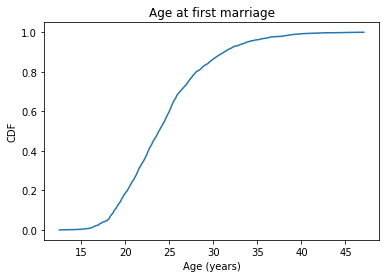

In [12]:
Cdf.from_seq(age_married).plot()

plt.xlabel('Age (years)')
plt.ylabel('CDF')
plt.title('Age at first marriage');

I was surprised to see so many women who report being married before age 18.  It's possible that some of these values are errors, but they are consistent with the NSFG codebook, so for purposes of this exploration I will take them at face value.

## Plotting lifelines

Because of the design of the NSFG, we observe different respondents at different ages.  Younger respondents who are not yet married are likely, but not certain, to get married in the future.  Older respondents who have never married probably won't, but they might.

The following figure is a graphical representation of the data we have.  For respondents who have married, it shows the time between birth and first marriage.  For respondents who have never married, it shows the time between birth the the date of interview.

In [13]:
def plot_lifelines(df, start, end1, end2):
    """Plot a line for each respondent.
    
    If end1 is valid, plot a line from start to end1;
    otherwise, plot a line from start to end2.
    
    df: DataFrame
    start: string variable for start time
    end1: string variable name for first end point
    end2: strong variable name for second end point
    """
    for y, row in df.iterrows():
        x1 = row[start]
    
        if np.isnan(row[end1]):
            # ongoing
            x2 = row[end2]
            plt.hlines(y, x1, x2, color='C0')
        else:
            # complete
            x2 = row[end1]
            plt.hlines(y, x1, x2, color='C1')
            plt.plot(x2, y, marker='o', color='C1')

Let's see what the lines look like for the first 20 respondents.

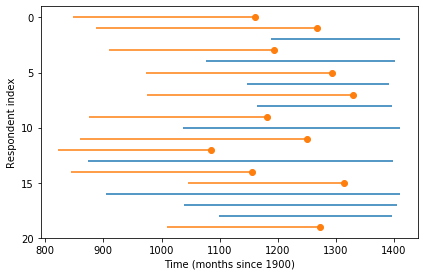

In [14]:
first20 = nsfg[:20]

plot_lifelines(first20, 'cmbirth', 'cmmarr1', 'cmintvw')
decorate(xlabel='Time (months since 1900)',
         ylim=[-1, 20],
         yticks=[0, 5, 10, 15, 20],
         ylabel='Respondent index')

plt.gca().invert_yaxis()

This diagram is meant to help you form a mental model of the data.

## Estimating survival

Now suppose we want to know the distribution of "survival time" from birth to first marriage.

For the respondents who have been married, we have all the data we need.

For the other respondents, we have only partial information; for example, if an unmarried respondent is age 35 at the time of interview, we don't know if or when she will be married.  But we can put a lower bound on it: she will not be married prior to age 35.

It might be tempting compute a survival curve using the data we have, and ignoring respondents who are not married.  Here's what it looks like:

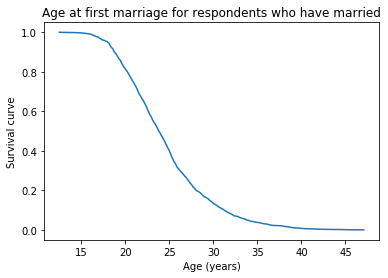

In [15]:
age_married = (nsfg['cmmarr1'] - nsfg['cmbirth']) /  12

surv_married = Surv.from_seq(age_married)
surv_married.plot()

plt.xlabel('Age (years)')
plt.ylabel('Survival curve')
plt.title('Age at first marriage for respondents who have married');

This survival curve shows ages at first myarriage, but only for respondents who have married.

If we want to know the distribution of ages for the whole population, this is not an accurate way to get it, for several reasons:

1) Because we selected only married respondents, it is not possible to estimate the fraction that never marry.

2) By selecting married respondents, we are more likely to sample people who marry young.

3) And we are less likely to select younger respondents.

So this way of estimating the survival curve is biased three times over!

Fortunately, there is a simple, unbiased way to estimate the survival curve using all of the data.

## Kaplan-Meier estimation

To understand Kaplan-Meier estimation, let's review the process we used in the previous notebook to compute survival and hazard functions.

As an example, suppose we observe three complete lifetimes that last 1, 3, and 6 years.

We can use `value_counts` to compute an unnormalized PMF:

In [16]:
complete = [1,3,6]
pmf = pd.value_counts(complete).sort_index()
pmf

1    1
3    1
6    1
dtype: int64

The CDF is the cumulative sum of the PMF:

In [17]:
cdf = pmf.cumsum()
cdf

1    1
3    2
6    3
dtype: int64

The survival function is the complement of the CDF, so we subtract from the total number of observations:

In [18]:
surv = 3 - cdf
surv

1    2
3    1
6    0
dtype: int64

The survival function indicates that 2 cases survived more than 1 year, 1 case survived more than 3 years, and no cases survived more than 6 year.

To compute the hazard rate, we compute the ratio of

1) The number of cases that ended at each time value, which is the PMF.

2) The number of cases that were alive and "at risk" at each time value, which is the sum of the PMF and the survival function.

So we compute the hazard function like this:

In [19]:
haz = pmf / (pmf + surv)
haz

1    0.333333
3    0.500000
6    1.000000
dtype: float64

The survival function indicates that 

1) Of the cases alive at 1 year, `1/3` ended.

2) Of the cases still alive at 3 years, `1/2` ended.

3) Of the cases still alive at 6 years, all ended.

In summary, when we have an unbiased sample of complete lifetimes, we can compute the hazard function by computing the PMF, CDF, and survival curve.

Now suppose that in addition to the complete cases at years 1, 3, and 6, we have another three cases that are observed alive at times 2, 3, and 5.

We can't compute the PMF, CDF, or survival function directly, but *we can estimate the hazard function*.  Then we can work backward to get the survival function, CDF, and PMF.

The process is almost the same as what we just saw.  To compute the hazard rate, we compute the ratio of

1) The number of cases that ended at each time value, which is the PMF.

2) The number of cases that were alive and "at risk" at each time value.

The difference is that we have to work a little harder to compute the number of cases at risk.

I'll start by computing the PMF for both the complete and ongoing cases.  This time I'll use unnormalized `Pmf` objects from `empiricaldist`: 

In [20]:
complete = [1,3,6]
ongoing = [2,3,5,7]

pmf_complete = Pmf.from_seq(complete, normalize=False)
pmf_ongoing = Pmf.from_seq(ongoing, normalize=False)

When we add two `Pmf` objects, the index of the result is the union of the two indices.

In [21]:
observed = pmf_complete + pmf_ongoing
ts = observed.qs
ts

array([1, 2, 3, 5, 6, 7])

Here's what the PMFs look like in a table.

In [22]:
df = pd.DataFrame(index=ts)
df['pmf_complete'] = pmf_complete
df['pmf_ongoing'] = pmf_ongoing
df

,pmf_complete,pmf_ongoing
1,1.0,NaN
2,NaN,1.0
3,1.0,1.0
5,NaN,1.0
6,1.0,NaN
7,NaN,1.0


We can use the PMFs to compute survival functions for the two groups

In [23]:
surv_complete = pmf_complete.make_surv()
surv_ongoing = pmf_ongoing.make_surv()

Then we evaluate the survival functions at the times when we observed the cases.

In [24]:
s_complete = surv_complete(ts)
s_ongoing = surv_ongoing(ts)

Here's what that looks like in the table.

In [25]:
df['s_complete'] = s_complete
df['s_ongoing'] = s_ongoing
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing
1,1.0,NaN,2.0,4.0
2,NaN,1.0,2.0,3.0
3,1.0,1.0,1.0,2.0
5,NaN,1.0,1.0,1.0
6,1.0,NaN,0.0,1.0
7,NaN,1.0,0.0,0.0


At each time step, `t`, the total number of cases at risk is the sum of:

1) The number cases that end at `t`, which is `pmf_complete`.

2) The number of ongoing cases observed at `t`, which is `pmf_ongoing`,

3) The number of complete cases that survive past `t`, which is `s_complete`.

4) The number of ongoing cases that survive past `t`, which is `s_complete`.

Here's what that looks like.

In [26]:
at_risk = pmf_complete + pmf_ongoing + s_complete + s_ongoing
df['at_risk'] = at_risk
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk
1,1.0,NaN,2.0,4.0,7.0
2,NaN,1.0,2.0,3.0,6.0
3,1.0,1.0,1.0,2.0,5.0
5,NaN,1.0,1.0,1.0,3.0
6,1.0,NaN,0.0,1.0,2.0
7,NaN,1.0,0.0,0.0,1.0


Finally, the hazard function is the ratio of `pmf_complete` and `at_risk`:

In [27]:
hazard = pmf_complete / at_risk

df['hazard'] = hazard
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard
1,1.0,NaN,2.0,4.0,7.0,0.142857
2,NaN,1.0,2.0,3.0,6.0,0.000000
3,1.0,1.0,1.0,2.0,5.0,0.200000
5,NaN,1.0,1.0,1.0,3.0,0.000000
6,1.0,NaN,0.0,1.0,2.0,0.500000
7,NaN,1.0,0.0,0.0,1.0,0.000000


With the hazard function, we can work backwards to compute the survival curve:

In [28]:
surv = (1 - hazard).cumprod()
df['surv'] = surv
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard,surv
1,1.0,NaN,2.0,4.0,7.0,0.142857,0.857143
2,NaN,1.0,2.0,3.0,6.0,0.000000,0.857143
3,1.0,1.0,1.0,2.0,5.0,0.200000,0.685714
5,NaN,1.0,1.0,1.0,3.0,0.000000,0.685714
6,1.0,NaN,0.0,1.0,2.0,0.500000,0.342857
7,NaN,1.0,0.0,0.0,1.0,0.000000,0.342857


And the CDF:

In [29]:
cdf = 1 - surv
df['cdf'] = cdf
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard,surv,cdf
1,1.0,NaN,2.0,4.0,7.0,0.142857,0.857143,0.142857
2,NaN,1.0,2.0,3.0,6.0,0.000000,0.857143,0.142857
3,1.0,1.0,1.0,2.0,5.0,0.200000,0.685714,0.314286
5,NaN,1.0,1.0,1.0,3.0,0.000000,0.685714,0.314286
6,1.0,NaN,0.0,1.0,2.0,0.500000,0.342857,0.657143
7,NaN,1.0,0.0,0.0,1.0,0.000000,0.342857,0.657143


And the PMF:

In [30]:
pmf = cdf.diff()
pmf[1] = cdf[1]

df['pmf'] = pmf
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard,surv,cdf,pmf
1,1.0,NaN,2.0,4.0,7.0,0.142857,0.857143,0.142857,0.142857
2,NaN,1.0,2.0,3.0,6.0,0.000000,0.857143,0.142857,0.000000
3,1.0,1.0,1.0,2.0,5.0,0.200000,0.685714,0.314286,0.171429
5,NaN,1.0,1.0,1.0,3.0,0.000000,0.685714,0.314286,0.000000
6,1.0,NaN,0.0,1.0,2.0,0.500000,0.342857,0.657143,0.342857
7,NaN,1.0,0.0,0.0,1.0,0.000000,0.342857,0.657143,0.000000


In this example, the survival function, CDF, and PMF are normalized.

In [31]:
pmf.sum()

0.657142857142857

That's because the case with the highest value of `t` is a complete case.

As an exercise, go back and add an ongoing case with `t=7`.  If you run this section again, you should see that the estimated distributions are not normalized.

## Marriage survival curves

The following function encapsulates the steps in the previous section.

In [32]:
def kaplan_meier(complete, ongoing):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    
    returns: Hazard object
    """
    pmf_complete = Pmf.from_seq(complete, normalize=False)
    pmf_ongoing = Pmf.from_seq(ongoing, normalize=False)
    
    observed = pmf_complete + pmf_ongoing
    ts = observed.qs

    surv_complete = pmf_complete.make_surv()
    surv_ongoing = pmf_ongoing.make_surv()

    s_complete = surv_complete(ts)
    s_ongoing = surv_ongoing(ts)

    at_risk = pmf_complete + pmf_ongoing + s_complete + s_ongoing
    hazard = pmf_complete / at_risk

    return Hazard(hazard)

We can test it with the example from the previous section.

In [33]:
kaplan_meier(complete, ongoing)

,probs
1,0.142857
2,0.000000
3,0.200000
5,0.000000
6,0.500000
7,0.000000


Now let's use it with the marriage data.

Again, here's the Boolean Series that tells us who has been married.

In [34]:
ever_married = nsfg['cmmarr1'].notna()
ever_married.value_counts()

True     3019
False    2535
Name: cmmarr1, dtype: int64

We've already computed `age_married`, but here it is again:

In [35]:
age_married = (nsfg['cmmarr1'] - nsfg['cmbirth']) /  12

And here are the ages at interview.

In [36]:
age_interview = (nsfg['cmintvw'] - nsfg['cmbirth']) /  12

`age_married` is only valid for respondents who have been married.  But just to be explicit, I'll use `ever_married` to select ages for respondents who have been married.

In [37]:
complete = age_married[ever_married]
complete.count()

3019

`age_interview` is valid for all respondents, including the ones who have been married.

So I'll use `~ever_married` to select only respondents who have never married.

In [38]:
ongoing = age_interview[~ever_married]
ongoing.count()

2535

Now we can estimate the hazard function.

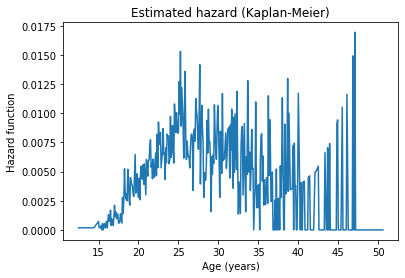

In [39]:
hazard_km = kaplan_meier(complete, ongoing)
hazard_km.plot()

plt.xlabel('Age (years)')
plt.ylabel('Hazard function')
plt.title('Estimated hazard (Kaplan-Meier)');

Hazard functions are noisy and plotting them is not particularly informative.

To see where the hazard rate is relatively high or low, we can plot the cumulative hazard:

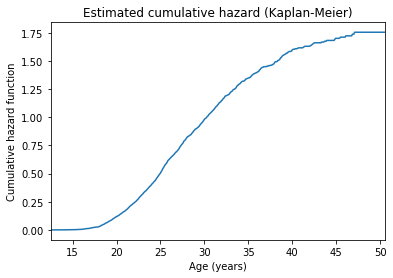

In [40]:
hazard_km.cumsum().plot()

plt.xlabel('Age (years)')
plt.ylabel('Cumulative hazard function')
plt.title('Estimated cumulative hazard (Kaplan-Meier)');

The cumulative hazard function is steepest between ages 20 and 35, with diminishing slope after that.

We can also use the hazard function to compute the survival function:

In [41]:
surv_km = hazard_km.make_surv()

I'll plot the survival function we estimated with Kaplan-Meier along with the survival curve for married respondents only.

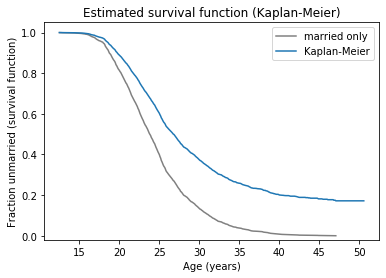

In [42]:
surv_married.plot(color='gray', label='married only')
surv_km.plot(label='Kaplan-Meier')

plt.xlabel('Age (years)')
plt.ylabel('Fraction unmarried (survival function)')
plt.title('Estimated survival function (Kaplan-Meier)')
plt.ylim(-0.02, 1.05)
plt.legend();

This plot shows why K-M estimation is necessary.  If we just discard incomplete cases, we get a very different survival curve.

We can use the survival function to estimate the fraction of the population unmarried at various ages:

In [43]:
surv_km([20, 30, 40, 50])

array([0.88932029, 0.37301966, 0.20064763, 0.17178612])

We can also use it to compute the CDF:

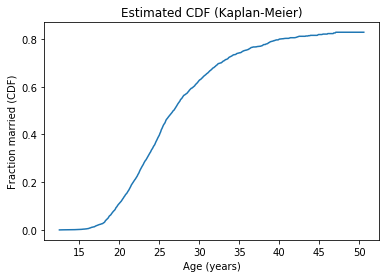

In [44]:
cdf_km = surv_km.make_cdf()
cdf_km.plot()

plt.xlabel('Age (years)')
plt.ylabel('Fraction married (CDF)')
plt.title('Estimated CDF (Kaplan-Meier)');

And with the CDF we can compute statistics like the 25th, 50th, and 75th percentiles of marriage age:

In [45]:
cdf_km.inverse([0.25, 0.5, 0.75])

array([22.58333333, 26.83333333, 35.58333333])

Finally, we can compute the PMF:

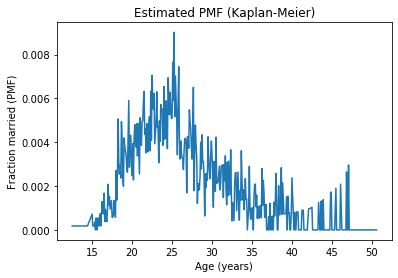

In [46]:
pmf_km = cdf_km.make_pmf()
pmf_km.plot()

plt.xlabel('Age (years)')
plt.ylabel('Fraction married (PMF)')
plt.title('Estimated PMF (Kaplan-Meier)');

The PMF is noisy, so the plot is not very informative.

## Changes in marriage patterns

Let's explore differences in marriage patterns between women born before and after 1980.

To make it easier, I'll put the steps from the previous section in a function.

In [47]:
def estimate_marriage_curve(df):
    """
    """
    age_married = (df['cmmarr1'] - df['cmbirth']) /  12
    age_interview = (df['cmintvw'] - df['cmbirth']) /  12
    
    ever_married = df['cmmarr1'].notna()
    complete = age_married[ever_married]
    ongoing = age_interview[~ever_married]

    hazard = kaplan_meier(complete, ongoing)
    surv = hazard.make_surv()
    return surv

Text(0.5, 1.0, 'Year of birth')

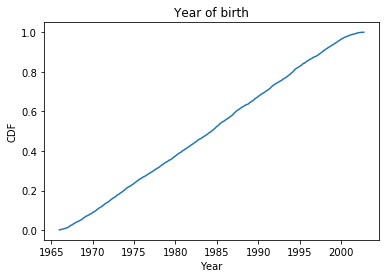

In [48]:
birth_year = 1900 + nsfg['cmbirth'] / 12
cdf = Cdf.from_seq(birth_year)
cdf.plot()

plt.xlabel('Year')
plt.ylabel('CDF')
plt.title('Year of birth')

In [49]:
before = (birth_year < 1980)
after = (birth_year >= 1980)

In [50]:
before.sum(), after.sum()

(2069, 3485)

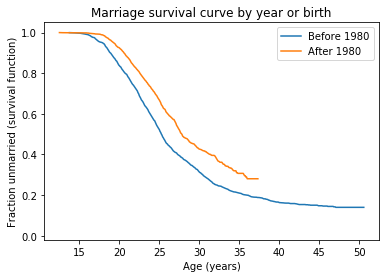

In [51]:
surv_before = estimate_marriage_curve(nsfg[before])
surv_before.plot(label='Before 1980')

surv_after = estimate_marriage_curve(nsfg[after])
surv_after.plot(label='After 1980')

plt.xlabel('Age (years)')
plt.ylabel('Fraction unmarried (survival function)')
plt.title('Marriage survival curve by year or birth')
plt.ylim(-0.02, 1.05)
plt.legend();

## lifelines

In [52]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [53]:
E = ever_married = nsfg['cmmarr1'].notna()
E.value_counts()

True     3019
False    2535
Name: cmmarr1, dtype: int64

In [54]:
T = age_married.fillna(age_interview)
T.describe()

count    5554.000000
mean       25.251560
std         6.826976
min        12.500000
25%        20.416667
50%        23.916667
75%        28.500000
max        50.583333
dtype: float64

In [55]:
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 5554 total observations, 2535 right-censored observations>

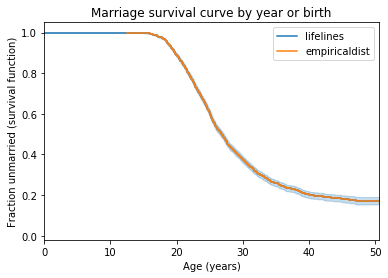

In [56]:
kmf.plot(label='lifelines')
surv_km.step(label='empiricaldist')

plt.xlabel('Age (years)')
plt.ylabel('Fraction unmarried (survival function)')
plt.title('Marriage survival curve by year or birth')
plt.ylim(-0.02, 1.05)
plt.legend();

In [57]:
max(abs(kmf.survival_function_['KM_estimate'] - surv_km).dropna())

9.880984919163893e-15